# Model Comparison
By: Griffin Hosseinzadeh (2025 May 7)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We'll start by generating some synthetic data from a slightly more complicated model than usual. The true underlying model will be a straight line plus a sinusoid. Imagine, for example, that these data are measurements of the brightness of a variable star over time. It could have short-timescale oscillations in brightness while also increasing in average brightness over the long term. Let's model this as
$$ y_3(x) = m x + b + a\sin(2\pi x) $$
where the three model parameters are the slope $m$, the intercept $b$, and the amplitude of the oscillations $a$.
We're going to compare this model with a simpler model without the oscillations:
$$ y_2(x) = m x + b $$
When we have noisy data, we may not be able to tell the difference between these two models.

First, write both these models down as function. We will want to call them later on.

In [2]:
def model3(x, m, b, a):
    return  (m*x) + b + (a*np.sin(2*np.pi*x))

def model2(x, m, b):
    return   (m*x) + b

Generate 100 random points in the range $0<x<1$ and evaulate the true model ($y_3$) at these points given the parameters below. Then add Gaussian noise to each point using the value of $\sigma$ below. Plot your synthetic data set (with error bars) and visually compare it with your two proposed models.

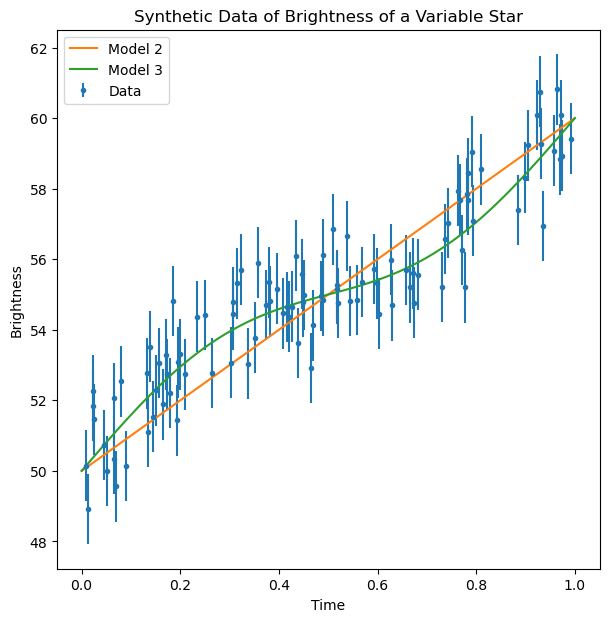

In [3]:
N = 100       # number of points
m_true = 10.  # slope
b_true = 50.  # intercept
a_true = 1.   # amplitude
sigma = 1.    # scatter

rng = np.random.default_rng(seed=13579)
x = rng.uniform(0,1,(N,))  # random values between 0 and 1
y_noise_free = model3(x, m_true, b_true, a_true) # clean true model
y = y_noise_free + np.random.normal(0, sigma, size=N) # noisy true model
dy = np.repeat(1., N)

x_model =  np.linspace(0,1.,N)
y_model2 =  model2(x_model, m_true, b_true)
y_model3 =  model3(x_model, m_true, b_true, a_true)

fig, ax = plt.subplots(figsize=(7,7))
ax.errorbar(x,y,dy,fmt='.',label='Data')
ax.plot(x_model,y_model2,label='Model 2')
ax.plot(x_model,y_model3,label='Model 3')
ax.legend()
ax.set_title('Synthetic Data of Brightness of a Variable Star')
ax.set_xlabel('Time')
ax.set_ylabel('Brightness')
plt.show()

From now on, we are pretending we don't know which model is true, or what the true values of the parameters are. We have a data set, and we want to figure out which model is a a better fit, and whether it is significantly better or not, given the different numbers of parameters.

For each model, write down functions for the logarithm of the prior, likelihood, and posterior. **Make sure your prior is properly normalized.** Use these functions to calculate the Bayesian evidence for each model. This is very similar to what we did in the Bayesian statistics exercise, with one additional step: numerical integration (`np.trapezoid`) of the entire posterior grid.

In [4]:
m_min = 0.5  # technically cannot be =0 for a log-uniform prior
m_max = 99.5
b_min = 0.5
b_max = 99.5


def log_prior2(theta):
    """
    Returns normalized prior for a given parameter vector
    for model 2.
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    
    Returns
    -------
    ln_prior: float
        Natural log of the normalized prior probability function
    """
    
    m, b = theta

    if m_min <= m <= m_max and b_min <= b <= b_max:
        
        norm_m = 1/(m_max - m_min)
        norm_b = 1/(b_max - b_min)
        
        ln_m_prior = np.log(norm_m)
        ln_b_prior = np.log(norm_b)
        
        ln_prior = ln_m_prior + ln_b_prior
        
        return ln_prior
    
    else: 
        return -np.inf

def log_likelihood2(theta, x, y, dy):
    """
    Returns log(likelihood) for a given parameter vector
    for model 2.
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    
    x: list, array-like
        List of independent variables from data
        
    y: list, array-like
        List of dependent variables from data
        
    dy: list, array-like
        List of errors from your y-data
    
    Returns
    -------
    ln_likelihood: float
        Natural log of the likelihood probability function
    """
    
    m, b = theta
    
    y_model = model2(x, m, b)
    
    all_ln_likelihoods = -1 * 0.5 * (np.log(2 * np.pi * dy ** 2) + (((y - y_model) / dy) **2))
    
    ln_likelihood = np.sum(all_ln_likelihoods)
    
    return ln_likelihood


def log_posterior2(theta, x, y, dy):
    """
    Returns log(posterior) for a given parameter vector
    for model 2.
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
        
    x: list, array-like
        List of independent variables from data
        
    y: list, array-like
        List of dependent variables from data
        
    dy: list, array-like
        List of errors from your y-data
        
    Returns
    -------
    ln_posterier: float
        Natural log of the posterior probabilty function
    """
    log_prior = log_prior2(theta)
    
    if np.isfinite(log_prior) == False:
        return -np.inf
    
    log_posterior = log_prior + log_likelihood2(theta, x, y, dy)
    
    return log_posterior


m_range2 =  np.linspace(m_min,m_max,100)
b_range2 =  np.linspace(b_min,b_max,100)

posterior_grid2 = np.empty((len(m_range2), len(b_range2)))

for i, m in enumerate(m_range2):
    for j, b in enumerate(b_range2):
        posterior_grid2[i,j] = log_posterior2((m,b), x, y, dy)
        
log_max2 = np.max(posterior_grid2)
posterior_grid2 = np.exp(posterior_grid2 - log_max2)

evidence2 =  np.trapz(np.trapz(posterior_grid2, b_range2,axis=1), m_range2)
print(evidence2)

1.0399187400099827


In [5]:
a_min = 0.1
a_max = 10.


def log_prior3(theta):
    """
    Returns normalized prior for a given parameter vector
    for model 3.
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    
    Returns
    -------
    ln_prior: float
        Natural log of the normalized prior probability function
    """
    
    m, b, a = theta

    if m_min <= m <= m_max and b_min <= b <= b_max and a_min <= a <= a_max:
        
        norm_m = 1/(m_max - m_min)
        norm_b = 1/(b_max - b_min)
        norm_a = 1/(a_max - a_min)
        
        ln_m_prior = np.log(norm_m)
        ln_b_prior = np.log(norm_b)
        ln_a_prior = np.log(norm_a)
        
        ln_prior = ln_m_prior + ln_b_prior + ln_a_prior
        
        return ln_prior
    
    else: 
        return -np.inf

def log_likelihood3(theta, x, y, dy):
    """
    Returns log(likelihood) for a given parameter vector
    for model 3.
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    
    x: list, array-like
        List of independent variables from data
        
    y: list, array-like
        List of dependent variables from data
        
    dy: list, array-like
        List of errors from your y-data
    
    Returns
    -------
    ln_likelihood: float
        Natural log of the likelihood probability function
    """
    
    m, b, a = theta
    
    y_model = model3(x, m, b, a)
    
    all_ln_likelihoods = -1 * 0.5 * (np.log(2 * np.pi * dy ** 2) + (((y - y_model) / dy) **2))
    
    ln_likelihood = np.sum(all_ln_likelihoods)
    
    return ln_likelihood



def log_posterior3(theta, x, y, dy):
    """
    Returns log(posterior) for a given parameter vector
    for model 3.
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
        
    x: list, array-like
        List of independent variables from data
        
    y: list, array-like
        List of dependent variables from data
        
    dy: list, array-like
        List of errors from your y-data
        
    Returns
    -------
    ln_posterier: float
        Natural log of the posterior probabilty function
    """
    log_prior = log_prior3(theta)
    
    if np.isfinite(log_prior) == False:
        return -np.inf
    
    log_posterior = log_prior + log_likelihood3(theta, x, y, dy)
    
    return log_posterior


m_range3 =  np.linspace(m_min, m_max, 100)
b_range3 =  np.linspace(b_min, b_max, 100)
a_range3 =  np.linspace(a_min, a_max, 100)

posterior_grid3 = np.empty((len(m_range3), len(b_range3), len(a_range3)))

for i, m in enumerate(m_range3):
    for j, b in enumerate(b_range3):
        for k, a in enumerate(a_range3):
            posterior_grid3[i,j] = log_posterior3((m,b,a), x, y, dy)
      
    
    

posterior_grid3 = np.exp(posterior_grid3 - np.max(posterior_grid3))
evidence3 =  np.trapz(np.trapz(np.trapz(posterior_grid3, a_range3, axis=2), 
                               b_range3, axis=1),
                      m_range3)

print(evidence3)

14.777508621425705


Calculate the odds ratio for the 3-parameter model compared to the 2-parameter model. What does this number tell you? Does it agree with your intuition from the plot you made above?

In [6]:
print("Odds Ratio = E(3)/E(2) = ", evidence3 / evidence2)

Odds Ratio = E(3)/E(2) =  14.21025321775031


This is not a large difference for the odds ratio. It's like the plot, where they both look like a good fit for the amount of data we have.

Now calculate the Akaike and Bayesian information criteria (AIC & BIC). For the sake of time, do not worry about determining the actual maximum-likelihood parameter values. Just use the true parameter values we used to synthesize the data at the beginning of this notebook. (Presumably those should be close to the maximum-likelihood values.) What do the AIC and BIC tell you? Do they agree with the odds ratio and/or your intuition?

$$\text{AIC} = -2 ln\left[L^0(M)\right] + 2k + \frac{2k(k+1)}{N-k-1}$$

$$\text{BIC} \approx -2ln[E(M)]$$

In [7]:
def compute_aic(ln_L_M, k, N):
    """
    Returns Akaike Information Criterion for small samples.
    Use for both model 2 and model 3.
    
    Parameters
    ----------
    ln_L_M: float
        Log of the maximum likelihood for model 2 or model 3.
        
    k: float
        Number of parameters, length of theta.
        
    N: float
        Number of measurements, length of data.
        
    Returns
    -------
    aic: float
        The Akaike Information Criterion for the model.
    """
        
    return (-2 * ln_L_M)  +  (2 * k)  +  ((2 * k * (k + 1))/(N - k - 1))


m_range =  np.linspace(m_min, m_max, 100)
b_range =  np.linspace(b_min, b_max, 100)
a_range =  np.linspace(a_min, a_max, 100)

log_likelihoods2 = np.empty((len(m_range), len(b_range)))
log_likelihoods3 = np.empty((len(m_range), len(b_range), len(a_range)))

for i, m in enumerate(m_range):
    for j, b in enumerate(b_range):
        log_likelihoods2[i,j] = log_likelihood2((m,b), x, y, dy)
        for k, a in enumerate(a_range):
            log_likelihoods3[i,j] = log_likelihood3((m,b,a), x, y, dy)

            
            
            
            
ln_L_M2 = np.max(log_likelihoods2)
ln_L_M3 = np.max(log_likelihoods3)
N = len(y)
            
aic2 =  compute_aic(ln_L_M2, 2, N)
aic3 =  compute_aic(ln_L_M3, 3, N)
print(aic2, aic3, aic2 - aic3)

bic2 =  -2 * np.log(evidence2)
bic3 =  -2 * np.log(evidence3)
print(bic2, bic3, bic2 - bic3)

305.4066602339836 1869.7146017037392 -1564.3079414697556
-0.0782851509896563 -5.386212674263861 5.307927523274205


What do the AIC and BIC tell you? Do they agree with the odds ratio and/or your intuition?

The lower AIC and BIC tell us that it is a better fit for the data. Here, AIC tells us that model 2 is better than model 3. BIC tells us that model 3 is slightly better than model 2. They do not agree with each, but this makes me conclude that less parameters for model 2 is a better fit for this model. 

Now repeat this entire notebook using a different data set with increased noise. Either duplicate this entire notebook (File > Duplicate), in which case you need to add that new notebook to the GitHub repository, or copy all the code cells above and paste them below. *(Yes, you could just change the number and rerun the notebook, but we want to see a record of both.)*

This time, increase $\sigma$ to 5. Comment on your results, specifically whether or not you can distinguish between the two models, and whether you think that is reasonable or not.

# New Data

## My Comments on My Results
Below, I duplicated the notebook with different x values and sigma = 5. It seems that there have been no large differences when increasing the noise. There is less bias towards model 2, and it seems that both models work well, with the odds ratio leaning a little more towards model 3. The AIC and BIC are close and there seems to be no strong evidence that one model is better than the other. Specifically for BIC, there is positive evidence that model 3 fits better than model 2.

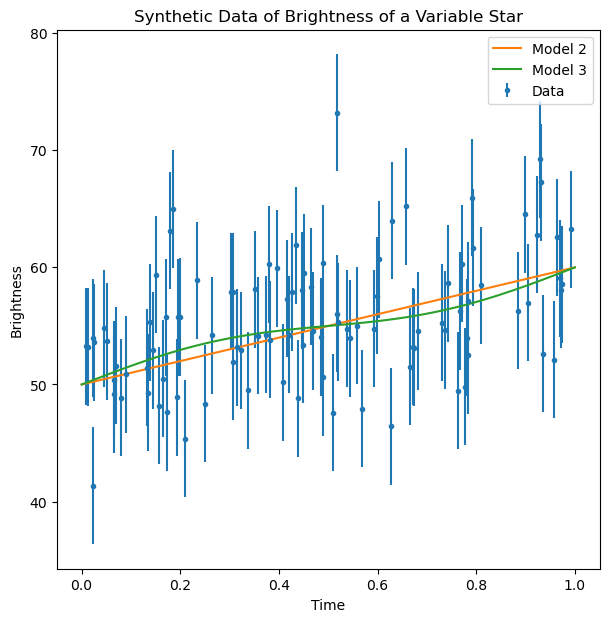

In [8]:
def model3(x, m, b, a):
    return  (m*x) + b + (a*np.sin(2*np.pi*x))

def model2(x, m, b):
    return   (m*x) + b


# CHANGE DATA, INCREASE NOISE

N = 100       # number of points
m_true = 10.  # slope
b_true = 50.  # intercept
a_true = 1.   # amplitude
sigma = 5.    # scatter

rng = np.random.default_rng(seed=13579)
x = rng.uniform(0,1,(N,))  # random values between 0 and 1
y_noise_free = model3(x, m_true, b_true, a_true) # clean true model
y = y_noise_free + np.random.normal(0, sigma, size=N) # noisy true model
dy = np.repeat(sigma, N)

x_model =  np.linspace(0,1.,N)
y_model2 =  model2(x_model, m_true, b_true)
y_model3 =  model3(x_model, m_true, b_true, a_true)

fig, ax = plt.subplots(figsize=(7,7))
ax.errorbar(x,y,dy,fmt='.',label='Data')
ax.plot(x_model,y_model2,label='Model 2')
ax.plot(x_model,y_model3,label='Model 3')
ax.legend()
ax.set_title('Synthetic Data of Brightness of a Variable Star')
ax.set_xlabel('Time')
ax.set_ylabel('Brightness')
plt.show()

In [9]:
m_min = 0.5  # technically cannot be =0 for a log-uniform prior
m_max = 99.5
b_min = 0.5
b_max = 99.5


def log_prior2(theta):
    """
    Returns normalized prior for a given parameter vector
    for model 2.
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    
    Returns
    -------
    ln_prior: float
        Natural log of the normalized prior probability function
    """
    
    m, b = theta

    if m_min <= m <= m_max and b_min <= b <= b_max:
        
        norm_m = 1/(m_max - m_min)
        norm_b = 1/(b_max - b_min)
        
        ln_m_prior = np.log(norm_m)
        ln_b_prior = np.log(norm_b)
        
        ln_prior = ln_m_prior + ln_b_prior
        
        return ln_prior
    
    else: 
        return -np.inf

def log_likelihood2(theta, x, y, dy):
    """
    Returns log(likelihood) for a given parameter vector
    for model 2.
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    
    x: list, array-like
        List of independent variables from data
        
    y: list, array-like
        List of dependent variables from data
        
    dy: list, array-like
        List of errors from your y-data
    
    Returns
    -------
    ln_likelihood: float
        Natural log of the likelihood probability function
    """
    
    m, b = theta
    
    y_model = model2(x, m, b)
    
    all_ln_likelihoods = -1 * 0.5 * (np.log(2 * np.pi * dy ** 2) + (((y - y_model) / dy) **2))
    
    ln_likelihood = np.sum(all_ln_likelihoods)
    
    return ln_likelihood


def log_posterior2(theta, x, y, dy):
    """
    Returns log(posterior) for a given parameter vector
    for model 2.
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
        
    x: list, array-like
        List of independent variables from data
        
    y: list, array-like
        List of dependent variables from data
        
    dy: list, array-like
        List of errors from your y-data
        
    Returns
    -------
    ln_posterier: float
        Natural log of the posterior probabilty function
    """
    log_prior = log_prior2(theta)
    
    if np.isfinite(log_prior) == False:
        return -np.inf
    
    log_posterior = log_prior + log_likelihood2(theta, x, y, dy)
    
    return log_posterior


m_range2 =  np.linspace(m_min,m_max,100)
b_range2 =  np.linspace(b_min,b_max,100)

posterior_grid2 = np.empty((len(m_range2), len(b_range2)))

for i, m in enumerate(m_range2):
    for j, b in enumerate(b_range2):
        posterior_grid2[i,j] = log_posterior2((m,b), x, y, dy)
        
log_max2 = np.max(posterior_grid2)
posterior_grid2 = np.exp(posterior_grid2 - log_max2)

evidence2 =  np.trapz(np.trapz(posterior_grid2, b_range2,axis=1), m_range2)
print(evidence2)

5.860073623552948


In [10]:
a_min = 0.1
a_max = 10.


def log_prior3(theta):
    """
    Returns normalized prior for a given parameter vector
    for model 3.
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    
    Returns
    -------
    ln_prior: float
        Natural log of the normalized prior probability function
    """
    
    m, b, a = theta

    if m_min <= m <= m_max and b_min <= b <= b_max and a_min <= a <= a_max:
        
        norm_m = 1/(m_max - m_min)
        norm_b = 1/(b_max - b_min)
        norm_a = 1/(a_max - a_min)
        
        ln_m_prior = np.log(norm_m)
        ln_b_prior = np.log(norm_b)
        ln_a_prior = np.log(norm_a)
        
        ln_prior = ln_m_prior + ln_b_prior + ln_a_prior
        
        return ln_prior
    
    else: 
        return -np.inf

def log_likelihood3(theta, x, y, dy):
    """
    Returns log(likelihood) for a given parameter vector
    for model 3.
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    
    x: list, array-like
        List of independent variables from data
        
    y: list, array-like
        List of dependent variables from data
        
    dy: list, array-like
        List of errors from your y-data
    
    Returns
    -------
    ln_likelihood: float
        Natural log of the likelihood probability function
    """
    
    m, b, a = theta
    
    y_model = model3(x, m, b, a)
    
    all_ln_likelihoods = -1 * 0.5 * (np.log(2 * np.pi * dy ** 2) + (((y - y_model) / dy) **2))
    
    ln_likelihood = np.sum(all_ln_likelihoods)
    
    return ln_likelihood



def log_posterior3(theta, x, y, dy):
    """
    Returns log(posterior) for a given parameter vector
    for model 3.
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
        
    x: list, array-like
        List of independent variables from data
        
    y: list, array-like
        List of dependent variables from data
        
    dy: list, array-like
        List of errors from your y-data
        
    Returns
    -------
    ln_posterier: float
        Natural log of the posterior probabilty function
    """
    log_prior = log_prior3(theta)
    
    if np.isfinite(log_prior) == False:
        return -np.inf
    
    log_posterior = log_prior + log_likelihood3(theta, x, y, dy)
    
    return log_posterior


m_range3 =  np.linspace(m_min, m_max, 100)
b_range3 =  np.linspace(b_min, b_max, 100)
a_range3 =  np.linspace(a_min, a_max, 100)

posterior_grid3 = np.empty((len(m_range3), len(b_range3), len(a_range3)))

for i, m in enumerate(m_range3):
    for j, b in enumerate(b_range3):
        for k, a in enumerate(a_range3):
            posterior_grid3[i,j] = log_posterior3((m,b,a), x, y, dy)
      
    
    

posterior_grid3 = np.exp(posterior_grid3 - np.max(posterior_grid3))
evidence3 =  np.trapz(np.trapz(np.trapz(posterior_grid3, a_range3, axis=2), 
                               b_range3, axis=1),
                      m_range3)

print(evidence3)

60.96955312297108


In [11]:
print("Odds Ratio = E(3)/E(2) = ", evidence3 / evidence2)

Odds Ratio = E(3)/E(2) =  10.404229885085538


In [12]:
def compute_aic(ln_L_M, k, N):
    """
    Returns Akaike Information Criterion for small samples.
    Use for both model 2 and model 3.
    
    Parameters
    ----------
    ln_L_M: float
        Log of the maximum likelihood for model 2 or model 3.
        
    k: float
        Number of parameters, length of theta.
        
    N: float
        Number of measurements, length of data.
        
    Returns
    -------
    aic: float
        The Akaike Information Criterion for the model.
    """
        
    return (-2 * ln_L_M)  +  (2 * k)  +  ((2 * k * (k + 1))/(N - k - 1))


m_range =  np.linspace(m_min, m_max, 100)
b_range =  np.linspace(b_min, b_max, 100)
a_range =  np.linspace(a_min, a_max, 100)

log_likelihoods2 = np.empty((len(m_range), len(b_range)))
log_likelihoods3 = np.empty((len(m_range), len(b_range), len(a_range)))

for i, m in enumerate(m_range):
    for j, b in enumerate(b_range):
        log_likelihoods2[i,j] = log_likelihood2((m,b), x, y, dy)
        for k, a in enumerate(a_range):
            log_likelihoods3[i,j] = log_likelihood3((m,b,a), x, y, dy)

            
            
            
            
ln_L_M2 = np.max(log_likelihoods2)
ln_L_M3 = np.max(log_likelihoods3)
N = len(y)
            
aic2 =  compute_aic(ln_L_M2, 2, N)
aic3 =  compute_aic(ln_L_M3, 3, N)
print(aic2, aic3, aic2 - aic3)

bic2 =  -2 * np.log(evidence2)
bic3 =  -2 * np.log(evidence3)
print(bic2, bic3, bic2 - bic3)

606.2332073912359 660.1751664854214 -53.94195909418556
-3.5363243345124697 -8.220749220870559 4.684424886358089
